# Two Class (Binary) Logistic Regression in Pytorch
> This is a practice notebook for implementing a two class logistic regression model in PyTorch. We will start by generating some synthetic data and then build an end-to-end pipeline to train a model. We will also see two ways to implement logistic regression models.

- toc: true 
- badges: true
- comments: true
- categories: [pytorch]
- keyword: [ml, dl, logistic, regression, pytorch]
- image: images/copied_from_nb/images/2022-10-11-pytorch-two-class-logistic-regression.jpeg

![](images/2022-10-11-pytorch-two-class-logistic-regression.jpeg)

## Introduction

In this notebook, we will train a logistic regression model using PyTorch. Given below is the summary of the steps followed in this notebook.
* Create a synthetic binary class dataset
* Split the data into `Train` and `Validation` datasets. Then convert them into mini-batches using PyTorch `DataLoader` class
* Create a Neural Net model configuration, an SGD optimizer, and a loss function
* Create a pipeline that will train the model on given data and update the weights based on the loss 
* Compare the results with scikit-learn logistic regression model

## Environment
This notebook is prepared with Google Colab.

In [19]:
#collapse
from platform import python_version
import sklearn, numpy, matplotlib, pandas

print("python==" + python_version())
print("sklearn==" + sklearn.__version__)
print("numpy==" + numpy.__version__)
print("torch==" + torch.__version__)
print("matplotlib==" + matplotlib.__version__)

python==3.7.14
sklearn==1.0.2
numpy==1.21.6
torch==1.12.1+cu113
matplotlib==3.2.2


## Credits
This notebook takes inspiration from the book "Deep Learning with PyTorch Step-by-Step" by "Daniel Voigt Godoy". You can get the book from its website: [pytorchstepbystep](https://pytorchstepbystep.com/). The GitHub repository for this book has valuable notebooks and can be used independently: [github.com/dvgodoy/PyTorchStepByStep](https://github.com/dvgodoy/PyTorchStepByStep). Parts of the code you see in this notebook are taken [chapter 3 notebook](https://colab.research.google.com/github/dvgodoy/PyTorchStepByStep/blob/master/Chapter03.ipynb) of the same book.

## Generate synthetic data

In this section, we will generate some data representing two interleaving half-circles using [sklearn.datasets.make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html). The purpose of this function is defined as

> Make two interleaving half circles. A simple toy dataset to visualize clustering and classification algorithms ... It generate 2d binary classification datasets that are challenging to certain algorithms (e.g. centroid-based clustering or linear classification), including optional Gaussian noise.

In [2]:
# data generation
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.3, random_state=0)
# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

# standardize data
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

Let's view the generated data.

In [ ]:
X_train[:10], y_train[:10]

Let's plot our generated data to see how it looks.

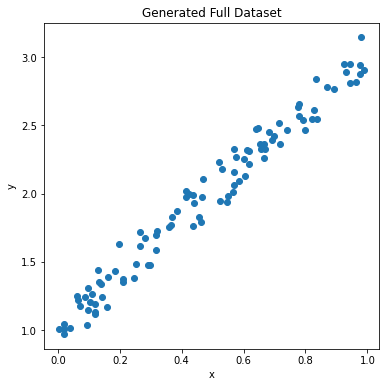

In [3]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 3, figsize=(15,5))
figure.suptitle('Train and Validation Dataset')

axes[0].set_title('Training Data')
axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train)

axes[1].set_title('Validation Data')
axes[1].scatter(X_val[:, 0], X_val[:, 1], c=y_val)

axes[2].set_title('Combined Data')
axes[2].scatter(X_train[:, 0], X_train[:, 1], c=y_train)
axes[2].scatter(X_val[:, 0], X_val[:, 1], c=y_val)
plt.show()

## Load generated data into PyTorch Dataset and DataLoader class

In this section, we will load our data in PyTorch helper classes Dataset and DataLoader. PyTorch documentation defines them as: [see [basics/data_tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)]

> Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.


For this, we first need to convert NumPy data arrays to PyTorch tensors.

In [4]:
# data preparation

import torch

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

Now load the tensors into Dataset and DataLoader class. PyTorch Datasets are helper classes that contain data and labels as a list of tuples. DataLoader is another helper class to create batches from Dataset tuples. `batch_size` means the number of tuples we want in a single batch. We have used 16 here since our data is small. So each fetch from DataLoader will give us a list of 16 tuples.

In [5]:
## 
# Load tensors into Dataset and DataLoader
from torch.utils.data import DataLoader, TensorDataset

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [ ]:
# pipeline
import numpy as np
import datetime
from torch.utils.tensorboard import SummaryWriter

class DeepLearningPipeline(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer
        
        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn
    
    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, 
            # since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn
            
    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and 
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None
            
        # Once the data loader and step function, this is the 
        # same mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Closes the writer
            self.writer.close()

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval() 
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

In [ ]:
# configure model
import torch.nn as nn
import torch.optim as optim

lr = 0.1

torch.manual_seed(42)
model_1 = nn.Sequential()
model_1.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer_1 = optim.SGD(model_1.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn_1 = nn.BCEWithLogitsLoss()

In [ ]:
n_epochs = 100

dlp_1 = DeepLearningPipeline(model_1, loss_fn_1, optimizer_1)
dlp_1.set_loaders(train_loader, val_loader)
dlp_1.train(n_epochs)

In [ ]:
fig = dlp_1.plot_losses()

In [ ]:
print(model_1.state_dict())

In [ ]:
from sklearn.metrics import confusion_matrix

logits_val = dlp_1.predict(X_val)
logits_val_tensor = torch.from_numpy(logits_val)
probabilities_val = torch.sigmoid(logits_val_tensor).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

In [ ]:
model_2 = nn.Sequential()
model_2.add_module('linear', nn.Linear(2, 1))
model_2.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer_2 = optim.SGD(model_2.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn_2 = nn.BCELoss(reduction='mean')

In [ ]:
n_epochs = 100

dlp_2 = DeepLearningPipeline(model_2, loss_fn_2, optimizer_2)
dlp_2.set_loaders(train_loader, val_loader)
dlp_2.train(n_epochs)

In [ ]:
fig = dlp_2.plot_losses()

In [ ]:
print(model_2.state_dict())

In [ ]:
from sklearn.metrics import confusion_matrix

probabilities_val = dlp_2.predict(X_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

In [ ]:
# comparison with sklearn logistic regression

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

In [ ]:
probabilities_val = logreg.predict(X_val)
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50